# Analisi della distribuzione di miscentering di ammassi eRosita - Marischa De La Cruz 

L'obiettivo di questo esercizio è analizzare la miscentering distribution degli ammassi di
galassie utilizzando i dati della prima data release di eROSITA. Il focus sarà sullo studio
della distribuzione delle distanze normalizzate (BCG_offset_R500) in relazione alla
massa (LogM500) e al redshift (BEST_Z) degli ammassi, e sulla creazione di modelli
predittivi basati sui parametri rho, sigma0 e sigma1.

In [891]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import emcee
import corner
import getdist 
from getdist import plots, MCSamples
!pip install tqdm 
import tqdm 
import scipy.stats 
from scipy.stats import chi2

In [892]:
#Configurazione di stile per i grafici , questa linea di codice aggiunge una griglia chiara su sfondo bianco nei vari grafici seguenti, utile per migliorare la leggibilità dei grafici
sns.set_style("whitegrid")

In [893]:
#rinomino il file CSV 
nome_file = "catalog_selected_columns_filtered_with_cluster_index.csv"

## Analisi del Catalogo
Il catalogo analizzato contiene 7567 ammassi di galassie con informazioni chiave tra cui il redshift (BEST_Z) che indica la distanza cosmologica degli ammassi, logM500 che rappresenta la massa dell’ammasso espressa come logaritmo della massa solare , la distanza normalizzata (BCG_offset_R500) che indica la misura del disallineamento tra il centro X e ottico.
In seguito si esamina la distribuzione delle distanze normalizzate (BCG_offset_R500) e la sua
variazione in funzione della massa e del redshift.

In [894]:
#Lettura del file con pandas , è una funzione di pandas che legge un file CSV e lo trasforma in un DataFrame (df), ovvero una struttura dati tabellare (simile a una tabella Excel)
df= pd.read_csv(nome_file)
from IPython.display import display      #Mostra il file CSV
display(df)
 


,Unnamed: 0,NAME,RA_XFIT,DEC_XFIT,M500,R500,RA_OPT,DEC_OPT,RA_BCG,DEC_BCG,...,X_scaled_0,X_scaled_1,cluster,rho_m,rho_s,sigma0_m,sigma0_s,sigma1_m,sigma1_s,logM500
0,0,1eRASS J000005.2-383729,0.0214,-38.6250,36.07,971.0,0.023800,-38.626781,0.023800,-38.626781,...,-0.081623,0.778435,6,0.750582,0.027508,0.100183,0.007995,0.668959,0.040839,14.557146
1,1,1eRASS J000021.4-824954,0.0558,-82.8189,16.99,819.0,0.176800,-82.798203,0.176800,-82.798203,...,-1.230286,-0.425019,7,0.726530,0.026114,0.062899,0.005056,0.606223,0.031481,14.230193
2,2,1eRASS J000031.8-630131,0.1265,-63.0225,22.04,846.0,0.125400,-63.023071,0.125400,-63.023071,...,-0.439542,-0.046329,9,0.809312,0.024625,0.089089,0.006957,0.578245,0.038856,14.343212
3,3,1eRASS J000056.7-682010,0.2309,-68.3369,14.25,732.0,0.230100,-68.336777,0.176500,-68.372871,...,-0.456453,-0.657230,26,0.779278,0.026525,0.103519,0.008066,0.620830,0.038000,14.153815
4,4,1eRASS J000104.0-464435,0.2768,-46.7381,23.84,891.0,0.284000,-46.734661,0.284000,-46.734661,...,-0.809294,0.075927,22,0.779619,0.029719,0.058439,0.005577,0.514526,0.037597,14.377306
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7562,7703,1eRASS J235805.6-403027,359.5230,-40.5073,11.51,692.0,359.557709,-40.486210,359.557709,-40.486210,...,-0.670809,-0.913151,26,0.779278,0.026525,0.103519,0.008066,0.620830,0.038000,14.061075
7563,7704,1eRASS J235848.7-612554,359.7070,-61.4319,21.82,800.0,359.700287,-61.433041,359.700287,-61.433041,...,0.278480,-0.061689,29,0.768367,0.033628,0.181056,0.018008,0.775150,0.052974,14.338855
7564,7705,1eRASS J235858.0-603644,359.6968,-60.6172,38.67,1071.0,359.767090,-60.609489,359.618896,-60.563850,...,-1.148322,0.905424,2,0.730593,0.032936,0.039728,0.003903,0.506667,0.035547,14.587374
7565,7706,1eRASS J235927.5-341821,359.8642,-34.3077,14.11,763.0,359.865387,-34.306438,359.865387,-34.306438,...,-1.104801,-0.669692,7,0.726530,0.026114,0.062899,0.005056,0.606223,0.031481,14.149527


In [895]:
#Selezione delle colonne corrette , questo blocco di codice estrae colonne specifiche dal DataFrame (df) e le assegna a variabili individuali
z = df["BEST_Z"]    #Redshift 
m = df["logM500"]   #Massa LogM500
d = df["BCG_offset_R500"]  #Distanze Normalizzate
r = df["rho_m"]
s_0 = df["sigma0_m"]
s_1 = df["sigma1_m"]


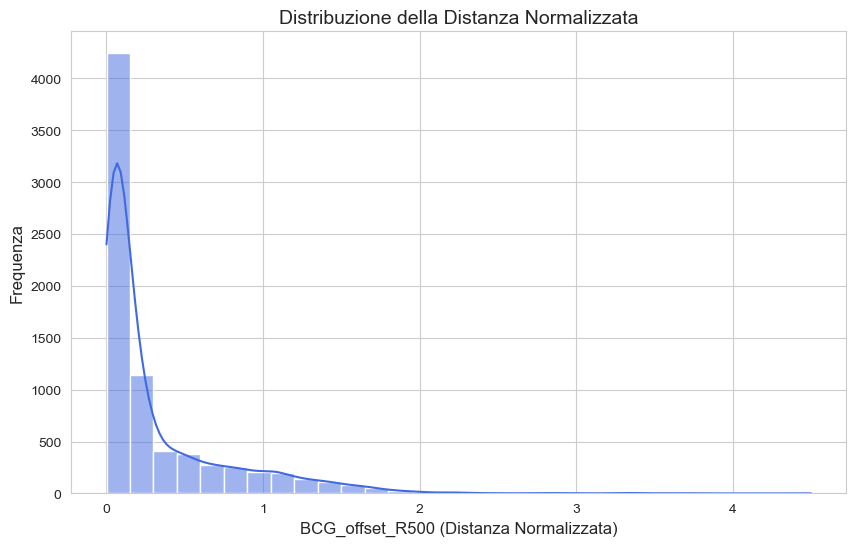

In [923]:
#Istogramma che rappresenta la distribuzione della distanza normalizzata
plt.figure(figsize=(10,6)) 
sns.histplot(d, bins=30, kde=True, color="royalblue") 
plt.xlabel("BCG_offset_R500 (Distanza Normalizzata)", fontsize=12)
plt.ylabel("Frequenza", fontsize=12)
plt.title("Distribuzione della Distanza Normalizzata", fontsize=14)
plt.show()

La distribuzione delle distanze normalizzate(BCG_offset_R500) mostra una distribuzione con un picco a valori bassi, segno che molti ammassi sono ben centrati, ma con una coda verso valori più alti, indicando la presenza di ammassi disallineati.



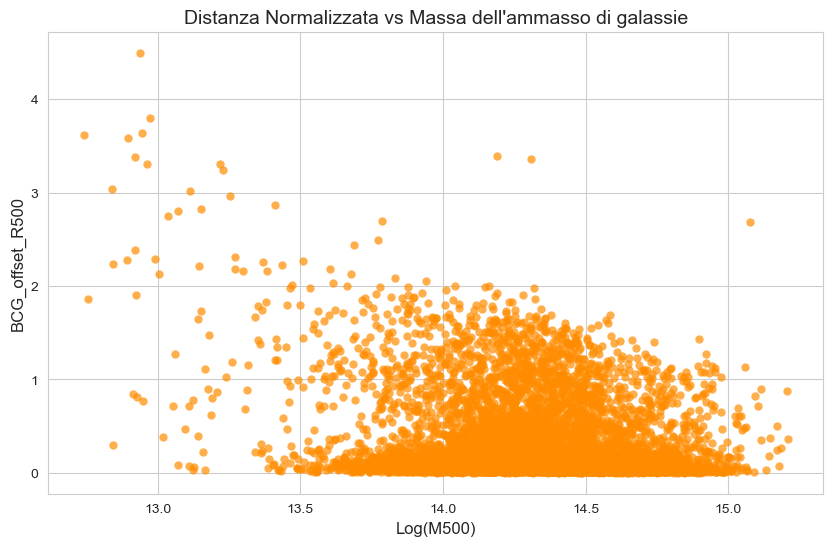

In [924]:
#Scatter plot:Distanza normalizzata vs Massa 
plt.figure(figsize=(10,6))
sns.scatterplot(x=m, y=d , alpha=0.7,color="darkorange", linewidth=0)
plt.xlabel("Log(M500)", fontsize=12)
plt.ylabel("BCG_offset_R500", fontsize=12)
plt.title("Distanza Normalizzata vs Massa dell'ammasso di galassie", fontsize=14)
plt.show()

Analizzando la relazione tra logM500 e BCG_offset_R500, si osserva una tendenza a miscentering minore per ammassi più massicci. Si nota che la dispersione tende a essere maggiore per ammassi meno massivi, mentre per ammassi più massivi la distribuzione è più concentrata quindi tendono a mostrare un disallineamento inferiore.

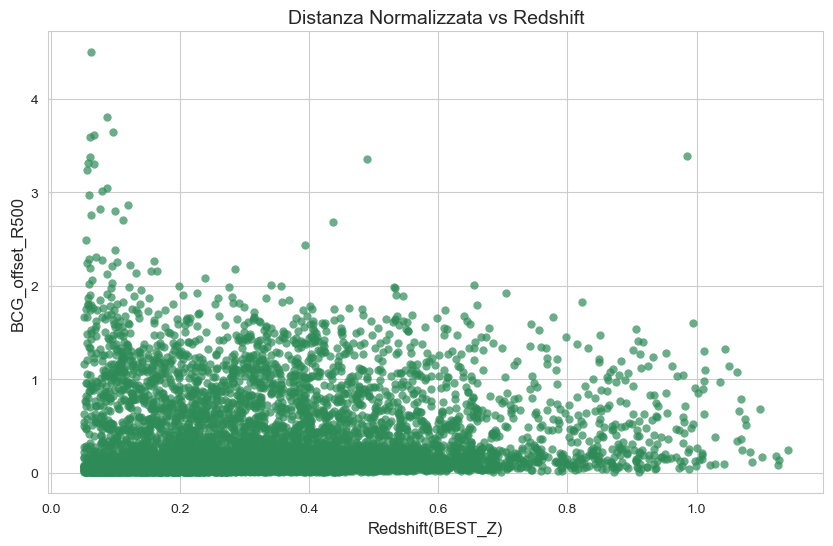

In [898]:
#Scatter plot: Distanza normalizzata vs Redshit 
plt.figure(figsize=(10,6))
sns.scatterplot(x=z, y=d, alpha=0.7, color="seagreen", linewidth=0)
plt.xlabel("Redshift(BEST_Z)", fontsize=12)
plt.ylabel("BCG_offset_R500", fontsize=12)
plt.title("Distanza Normalizzata vs Redshift", fontsize=14)
plt.show()

Guardando invece il grafico che mostra il BCG_offset_R500 in funzione del redshift , si deduce che il redshift (BEST_ Z)  sembra avere una correlazione più debole con il miscentering. Viene mostrata una leggera tendenza all’aumento della dispersione per ammassi ad alto redshift. Questo potrebbe suggerire un effetto evolutivo o una maggiore incertezza nelle misure a redshift elevati.

# Sviluppo dei Modelli 
In questa sezione ci si concentra sullo sviluppare modelli per predire la distribuzione osservata di distanza normalizzata “x” tra il centro determinato in banda X ed il centro determinato in banda ottica. In particolare si considerano i seguenti due modelli dove una frazione   $\rho$  di ammassi ben centrati viene descritta dal parametro $\sigma_0$ ,ed una frazione $1- \rho$ di ammassi centrati erroneamente viene descritta dal parametro $\sigma_1$.
In particolare si utilizzeranno i seguenti due modelli:

### Modello S15(Saro et al.2015)
$P(x | \rho, \sigma_0, \sigma_1) = \rho \cdot \frac{x}{\sigma_0^2} \cdot \exp\left( -0.5 \cdot \left( \frac{x}{\sigma_0} \right)^2 \right) + (1 - \rho) \cdot \frac{x}{\sigma_1^2} \cdot \exp\left( -0.5 \cdot \left( \frac{x}{\sigma_1} \right)^2 \right)$

### Modello Z19(Zhang et al.2019)
$P(x | \rho, \sigma_0, \sigma_1) = \rho \cdot \frac{1}{\sigma_0} \cdot \exp\left( -\frac{x}{\sigma_0} \right) + (1 - \rho) \cdot \frac{x}{\sigma_1^2} \cdot \exp\left( -\frac{x}{\sigma_1} \right)$

Prima di implementare i due modelli, è stata fatta preliminarmente una stima qualitativa dei parametri $\rho$ , $\sigma_0$ e $\sigma_1$ istogrammando le colonne rho_m, sigma_0_m e sigma_1_m del file "catalog_selected_columns_filtered_with_cluster_index.csv"

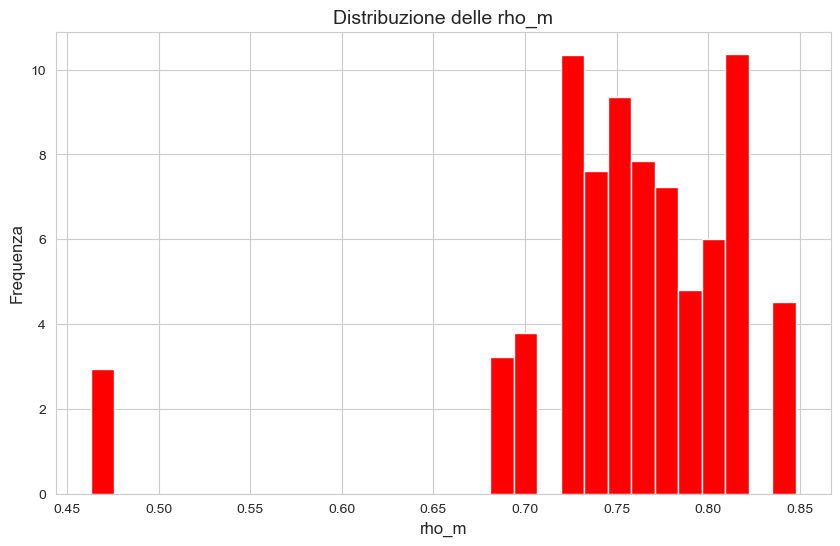

Stima qualitativa di rho_m: 0.75


In [925]:
#Secondo punto
#Stima dei parametri rho, sigma_0, sigma_1

#Stima di rho_m
plt.figure(figsize=(10,6))
plt.hist(r,bins=30, density=True, color="red")
plt.ylabel("Frequenza", fontsize=12)
plt.xlabel("rho_m", fontsize=12)
plt.title("Distribuzione delle rho_m", fontsize=14)
plt.show()
print("Stima qualitativa di rho_m: 0.75")


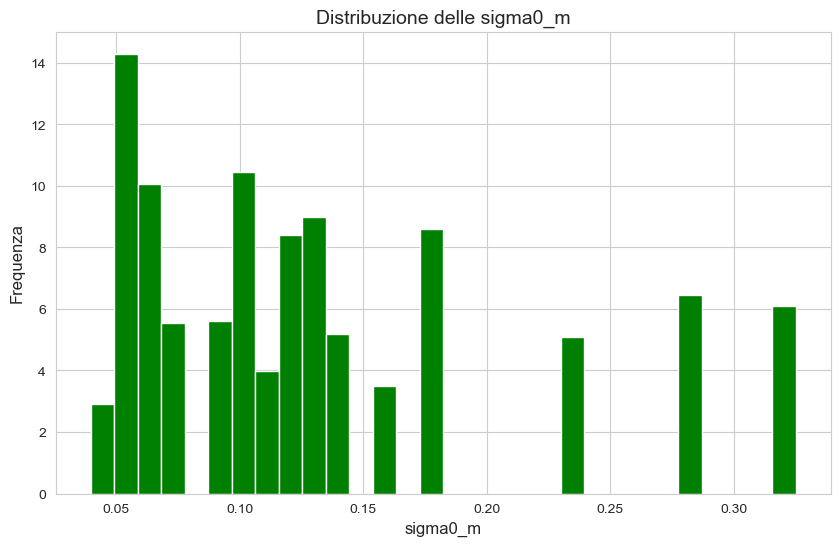

Stima qualitativa di sigma0_m: 0.1


In [901]:
#Stima di sigma0_m 
plt.figure(figsize=(10,6))
plt.hist(s_0, bins= 30, density=True, color="green")
plt.xlabel("sigma0_m", fontsize=12)
plt.ylabel("Frequenza", fontsize=12)
plt.title("Distribuzione delle sigma0_m", fontsize=14)
plt.show()
print("Stima qualitativa di sigma0_m: 0.1")

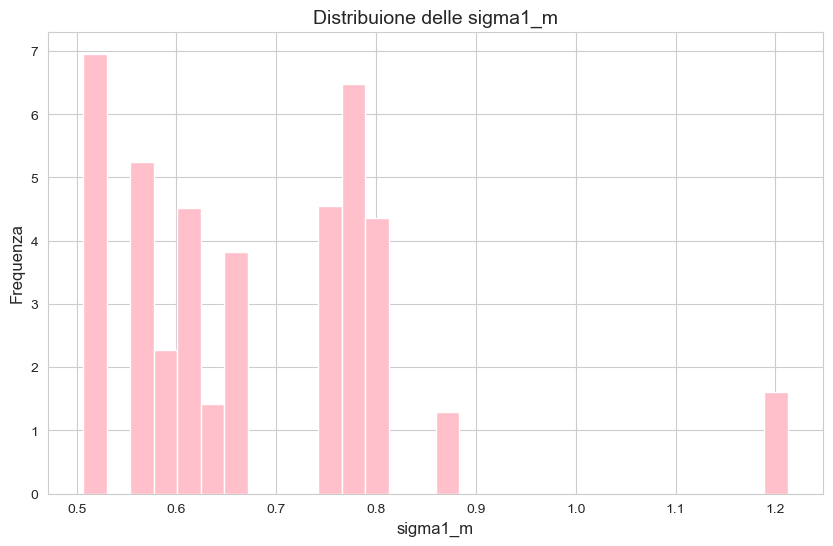

Stima qualitativa di sigma1_m: 0.65


In [914]:
#Stima di sigma1_m
plt.figure(figsize=(10,6))
plt.hist(s_1,bins=30,density=True, color="pink")
plt.xlabel("sigma1_m", fontsize=12)
plt.ylabel("Frequenza", fontsize=12)
plt.title("Distribuione delle sigma1_m", fontsize=14)
plt.show()
print("Stima qualitativa di sigma1_m: 0.65")



## Implementazione dei due modelli 

In [816]:
#Modello S15(Saro et al.2015)
def modello_S15(x,rho, sigma_0, sigma_1):
    term1=rho*(x/sigma_0**2)*np.exp(-0.5*(x/sigma_0)**2)
    term2=(1-rho)* (x/sigma_1**2)*np.exp(-0.5*(x/sigma_1)**2)
    return term1+term2
    

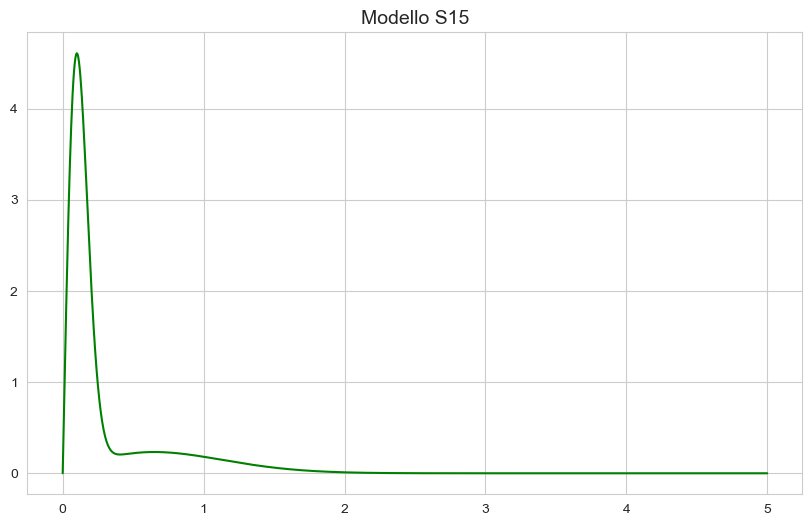

In [915]:
#Assegnazione dei valori ai vari parametri 
x_1=np.linspace(0,5,1000)  
rho_m=0.75
sigma_0_m=0.1

sigma_1_m = 0.65

y_1 = modello_S15(x_1, rho_m, sigma_0_m, sigma_1_m)  #Chiamata della funzione 

plt.figure(figsize=(10,6))   
plt.plot(x_1, y_1, color='green')
plt.title("Modello S15", fontsize=14)
plt.show()

Questo modello sembra rappresentare meglio la componente centrale della distribuzione di BCG_offset_R500, indicando una frazione più alta di ammassi ben centrati. Tuttavia, tende a sottostimare la coda della distribuzione.

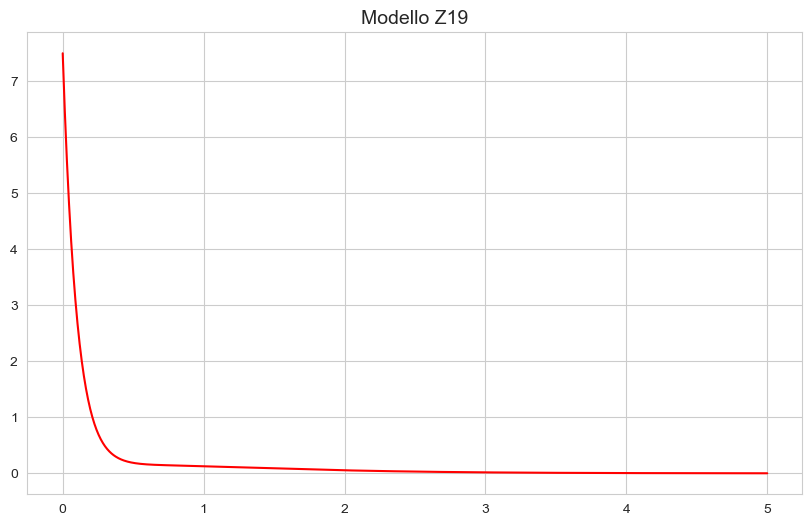

In [916]:
#Modello Z19(Zhang et al.2019)
def modello_Z19(x, rho, sigma_0, sigma_1):
    term1 = rho * (1/sigma_0) * np.exp(-x/sigma_0)
    term2 = (1-rho) * (x/sigma_1**2) * np.exp(-x/sigma_1)
    return term1+term2

x_2 = np.linspace(0,5,1000)
y_2 = modello_Z19(x_2, rho_m , sigma_0_m, sigma_1_m)   #Chiamata del modello 

plt.figure(figsize=(10,6))
plt.plot(x_2, y_2, color= "red")
plt.title("Modello Z19", fontsize=14)
plt.show()



A differenza di S15, questo modello mostra una migliore adattabilità alla coda della distribuzione, suggerendo una maggiore flessibilità nel descrivere gli ammassi con forti disallineamenti. Tuttavia, potrebbe sovrastimare la dispersione della componente ben centrata, riducendo la precisione nella descrizione degli ammassi più concentrati.

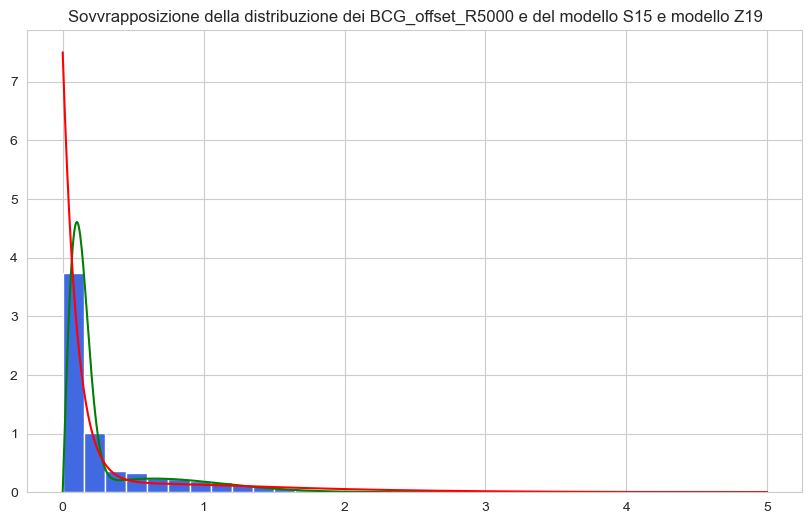

In [918]:
#Sovvrapposizione della Distribuzione delle Distanze Normalizzate e del modello S15 e modello Z19 
plt.figure(figsize=(10,6))
plt.hist(d,bins=30, density =True, color="royalblue")
plt.plot(x_1,y_1, color='green')
plt.plot(x_2, y_2, color = 'red')
plt.title("Sovvrapposizione della distribuzione dei BCG_offset_R5000 e del modello S15 e modello Z19")
plt.show()

Confrontando la distribuzione dei BCG_offset_R5000 con i due modelli si può notare che i risultati del fit e i dati osservati mostrano un buon accordo, anche se alcune discrepanze si notano nelle code della distribuzione. Questo suggerisce che il modello potrebbe essere migliorato includendo una componente aggiuntiva per descrivere meglio gli ammassi fortemente disallineati. In generale, S15 offre una descrizione più precisa del miscentering, mentre Z19 sembra più adatto a rappresentare le code della distribuzione, ma a costo di una maggiore incertezza nella componente centrale

## Introduzione all'algoritmo emcee e il suo utilizzo nell'analisi 
L'algoritmo emcee è un campionatore MCMC (Markov Chain Monte Carlo) basato sul metodo Affine Invariant Ensemble Sampler. È particolarmente usato in statistica bayesiana e nell'analisi dei dati astronomici per stimare distribuzioni di probabilità di parametri incerti.

In questo contesto l'emcee viene utilizzato per stimare i parametri dei due modelli di miscentering (S15 e Z19). L’algoritmo lavora generando un insieme di walker, che si muovono nello spazio dei parametri seguendo le probabilità definite dalla funzione di likelihood e dalla distribuzione a priori.
Il processo di campionamento permette di ottenere distribuzioni posteriori per i parametri di interesse (ρ, σ₀, σ₁), fornendo sia le stime più probabili che le incertezze associate. In sintesi, l'emcee consente di ottenere stime robuste dei parametri e di valutare quantitativamente quale modello meglio descrive la distribuzione del miscentering nei dati eROSITA.


In [820]:
#Terzo punto utilizzo dell'algoritmo emcee
#Funzione di log likelihood
def log_likelihood(theta, x, modello):
    rho, sigma_0, sigma_1 = theta 
    if sigma_0 <= 0 or sigma_1 <= 0 or not (0 < rho < 1):    
        return -np.inf    #togliamo parametri non validi 
    prob = modello(x, rho, sigma_0, sigma_1)
    prob[prob <= 0] = 1e-10  #Evita log(0)
    return np.sum(np.log(prob))
    

In [821]:
#Distribuzioni a priori(uniformi)
def log_prior(theta):
    rho, sigma_0, sigma_1 = theta 
    if 0 < rho < 1 and 0.001 < sigma_0 < 1 and 0.001 < sigma_1 < 1:
        return 0.0   #Prior uniforme
    return -np.inf   #Togliamo parametri fuori intervallo 
 

In [822]:
#Funzione di log probabilità a posteriori , accettare o non accettare i dati 
def log_probability(theta, x, modello):
    lp = log_prior(theta)
    if not np.isfinite(lp):
     return -np.inf
    return log_prior(theta) + log_likelihood(theta,x,modello)


In [823]:
#Caricamento dati 
dati = np.loadtxt("catalog_selected_columns_filtered_with_cluster_index.csv", delimiter=",", skiprows=1, usecols=18)  #prendo la colonna dei BCG_offset_R500


In [824]:
#Impostazioni MCMC
ndim = 3  #Numeri di parametri (rho, sigma_0, sigma_1)
nwalkers = 12  #Numeri di walkers , deve essere >= 2*ndim+1
np.random.seed(42)   #Un seed è un valore iniziale dato al generatore di numeri pseudocasuali. I numeri generati dai computer non sono veramente casuali, ma vengono calcolati da un algoritmo deterministico. Il seed permette di controllare questo processo.
#np.random.seed(42) è stata utilizzata perché eseguendo più volte un codice che genera numeri casuali ,in questo modo si possono ottenere sempre gli stessi risultati.

In [825]:
#Valori iniziali per i camminatori 
theta = np.array([0.65, 0.083, 0.50])    #Valori iniziali medi , l'emcee parte da questi 3 valori di rho, sigma_0, sigma_1  
pos = theta + 0.001 * np.random.randn(nwalkers, ndim)  

In [826]:
#Eseguiamo MCMC per il modello S15
sampler_S15 = emcee.EnsembleSampler(nwalkers, ndim, log_probability , args = (dati, modello_S15))
sampler_S15.run_mcmc(pos, 2000, progress=True)
samples_S15 = sampler_S15.get_chain()   

100%|██████████████████████████████████████| 2000/2000 [00:02<00:00, 743.43it/s]


In [827]:
#Tempo di autocorrelazione 
tau_corr1 = sampler_S15.get_autocorr_time(tol=0)      #L'autocorrelazione misura quanto ogni campione della catena MCMC dipende dai campioni precedenti. Un'alta autocorrelazione significa che i campioni esplorano lo spazio dei parametri in modo inefficiente, mentre una bassa autocorrelazione indica che i campioni sono più indipendenti
print(f"Tempo di autocorrelazione stimato:{tau_corr1}")

#Il tempo di autocorrelazione (τ) rappresenta il numero di passi necessario affinché la catena "dimentichi" il proprio stato precedente e fornisca nuovi campioni quasi indipendenti. In pratica:
#Se τ è basso, la catena converge rapidamente e i campioni sono ben distribuiti nello spazio dei parametri.
#Se τ è alto, potrebbe essere necessario un numero maggiore di iterazioni per ottenere una stima affidabile della distribuzione posteriore

Tempo di autocorrelazione stimato:[48.23893969 23.39259003 61.22987607]


In [828]:
#Eseguiamo MCMC per il modello Z19
sampler_Z19 = emcee.EnsembleSampler(nwalkers, ndim , log_probability , args=(dati, modello_Z19))
sampler_Z19.run_mcmc(pos, 2000, progress=True)
samples_Z19 = sampler_Z19.get_chain()

100%|██████████████████████████████████████| 2000/2000 [00:02<00:00, 825.24it/s]


In [829]:
#Tempo di autocorrelazione
tau_corr2 = sampler_Z19.get_autocorr_time(tol=0)
print(f"Tempo di autocorrelazione stimato:{tau_corr2}")


Tempo di autocorrelazione stimato:[ 55.43630913  50.95671005 101.08714464]


In [830]:
#Salviamo i dati della catena MCMC
np.save("MCMC_chain_Z19.npy", samples_Z19)

In [831]:
#Ricarichiamo la catena MCMC salvata (per S15)
samples_S15_loaded= np.load("MCMC_chain_S15.npy")

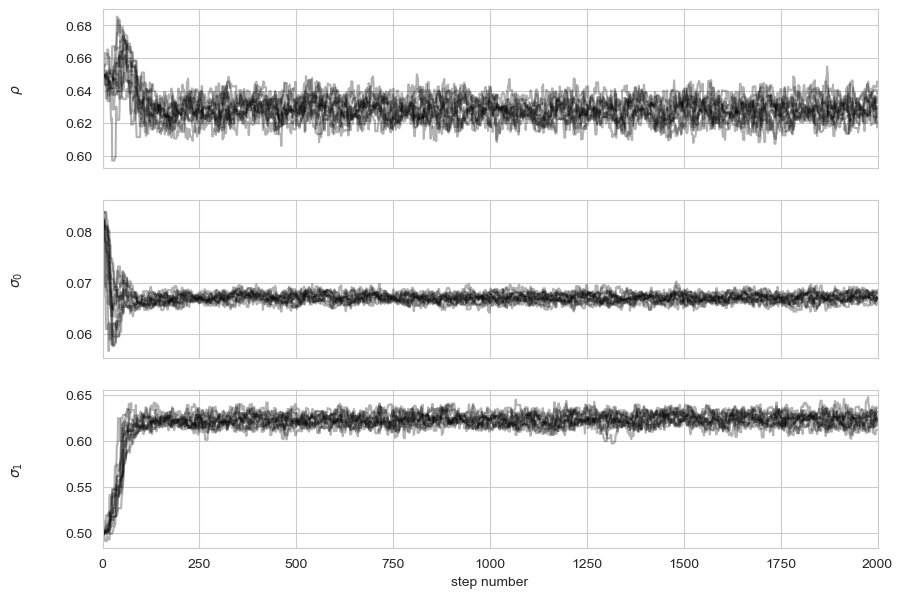

In [832]:
#Plot della catena MCMC per ogni parametro del modello S15
fig, axes = plt.subplots(3, figsize=(10,7), sharex=True)
labels = [r"$\rho$", r"$\sigma_0$", r"$\sigma_1$"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples_S15[:,:,i], "k", alpha=0.3)
    ax.set_xlim(0,len(samples_S15))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
axes[-1].set_xlabel("step number")
plt.show()

Le catene per i parametri sembrano stabilizzarsi rapidamente, con oscillazioni attorno a valori medi ben definiti. Questo indica una buona esplorazione dello spazio dei parametri e una convergenza relativamente veloce.

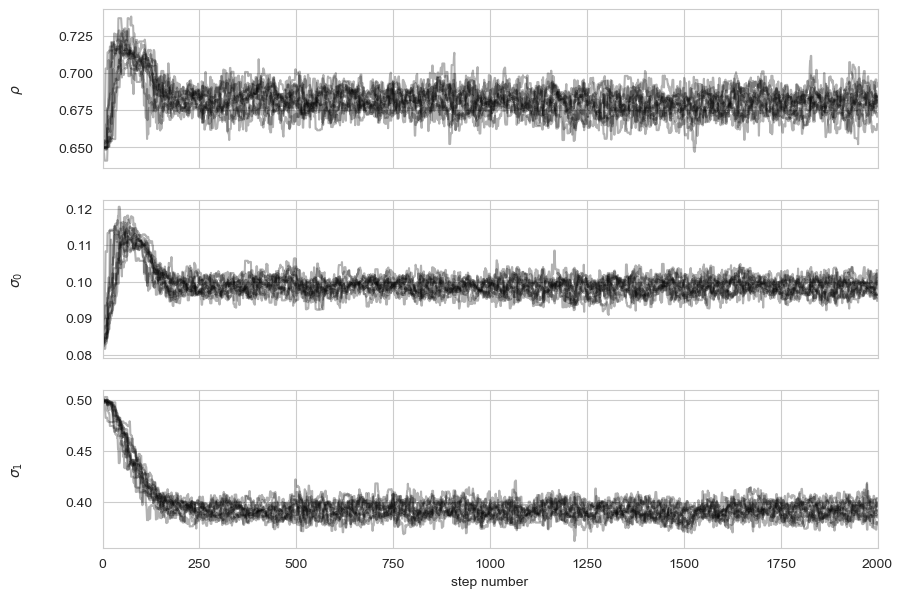

In [833]:
#Plot della catena MCMC per ogni parametro del modello Z19
fig, axes = plt.subplots(3, figsize=(10,7), sharex=True)
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples_Z19[:,:,i], "k", alpha=0.3)
    ax.set_xlim(0,len(samples_Z19))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1,0.5)
axes[-1].set_xlabel("step number")
plt.show()

Anche in questo caso, le catene mostrano una buona stabilità, ma potrebbero presentare una maggiore autocorrelazione, ossia i campioni successivi tendono a essere più correlati tra loro. Questo può suggerire che il modello richiede un numero maggiore di iterazioni per esplorare completamente lo spazio dei parametri o che l’efficienza del campionamento potrebbe essere migliorata.

In generale, se entrambe le catene appaiono stabili e non mostrano derive sistematiche, significa che i parametri stimati con emcee sono affidabili.

Removed no burn in
\rho = 0.6282\pm 0.0063
\rho mean= 0.6281836501099027 best fit= 0.6285002502024806
\sigma_0 = 0.06704\pm 0.00083
\sigma_0 mean= 0.06704228712497434 best fit= 0.06698733075533425
\sigma_1 = 0.6236\pm 0.0066
\sigma_1 mean= 0.6235680109797187 best fit= 0.6233825043529533


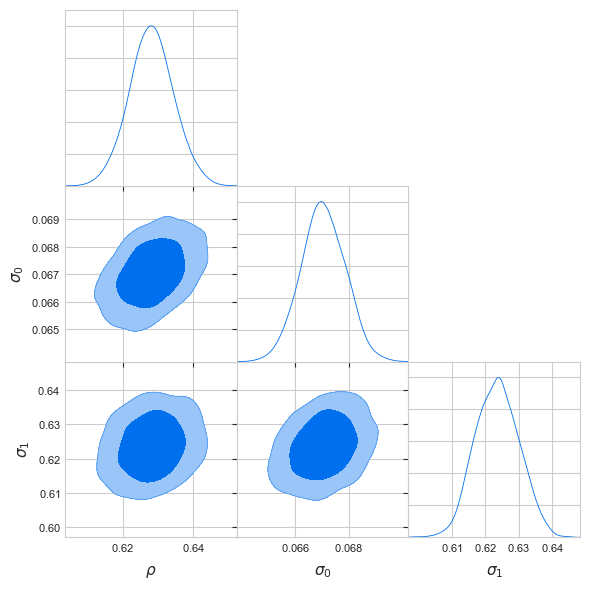

In [834]:
emcee_sample_S15 = sampler_S15.get_chain(discard=500, thin=2, flat =True)    
log_like_S15 = sampler_S15.get_log_prob(discard=500, thin=2, flat=True)
labels=["\\rho", "\\sigma_0", "\\sigma_1"]
names=["rho", "sigma_0", "sigma_1"]

samples_S15 = MCSamples(samples=emcee_sample_S15, names=names, labels=labels)
g = plots.getSubplotPlotter()
g.triangle_plot(samples_S15, filled=True)

means_S15 = np.zeros(ndim)
best_fits_S15 = np.zeros(ndim)
stats_S15 = samples_S15.getMargeStats()
for i in range(ndim):
    print(samples_S15.getInlineLatex(names[i], limit=1))   
    means_S15[i] = stats_S15.parWithName(names[i]).mean
    index = np.argwhere(log_like_S15 == np.amax(log_like_S15))
    best_fits_S15[i] = emcee_sample_S15[index.flatten()[0],i]
    print(labels[i], 'mean=', means_S15[i], 'best fit=', best_fits_S15[i])

#Il valor medio(mean) è il picco della distribuzione non è detto che coincida con il best fit, il mean ossia il valor medio è il punto dell'apice della distribuzione, mentre il 
#il best fit sono le zone di più alta probabilità della catena 

Questo grafico mostra le distribuzioni posteriori e le correlazioni tra i parametri $\rho$, $\sigma_0$ e $\sigma_1$ per il modello S15. I valori ottenuti indicano che: 

$\cdot$ $\rho$ ha un valore medio di circa 0.628 con il best fit a 0.6285, suggerendo una correlazione moderata tra le variabili. 

$\cdot$ $\sigma_0$ ha un valore medio di 0.06704, con il best fit leggermente inferiore (0.0669), suggerendo una dispersione abbastanza contenuta nei dati. 

$\cdot$ $\sigma_1$ ha un valore medio di 0.6236, con un best fit di 0.6233, che mostra una moderata incertezza.

Le distribuzioni mostrano una concentrazione ben definita, questo significa che il modello ha fissato bene i parametri senza grosse incertezze.

Removed no burn in
\rho = 0.6802\pm 0.0078
\rho mean= 0.6801563821018115 best fit = 0.6803002309832851
\sigma_0 = 0.0986\pm 0.0021
\sigma_0 mean= 0.09861038567154096 best fit = 0.09867149169795364
\sigma_1 = 0.3915\pm 0.0075
\sigma_1 mean= 0.3914759032415091 best fit = 0.39181543264739394


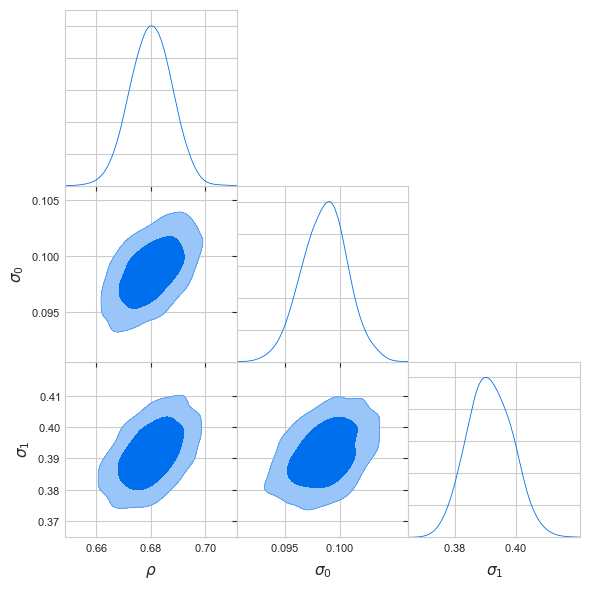

In [904]:
emcee_sample_Z19 = sampler_Z19.get_chain(discard=500, thin=2, flat=True)
log_like_Z19 = sampler_Z19.get_log_prob(discard=500, thin=2, flat=True)

samples_Z19 = MCSamples(samples=emcee_sample_Z19, names=names, labels=labels)
g = plots.getSubplotPlotter()
g.triangle_plot(samples_Z19, filled=True)

means_Z19 = np.zeros(ndim)
best_fits_Z19 = np.zeros(ndim)
stats_Z19 = samples_Z19.getMargeStats()
for i in range(ndim):
    print(samples_Z19.getInlineLatex(names[i], limit=1))    
    means_Z19[i] = stats_Z19.parWithName(names[i]).mean
    index = np.argwhere(log_like_Z19 == np.amax(log_like_Z19))
    best_fits_Z19[i] = emcee_sample_Z19[index.flatten()[0],i]
    print(labels[i], 'mean=',means_Z19[i], 'best fit =', best_fits_Z19[i])
    #best_fits_Z19[i] = emcee_sample_Z19[np.argmax(log_like_Z19),i]
    #print(labels[i], 'best fit=', best_fits_Z19[i])

Questo grafico rappresenta la stessa analisi per il secondo modello Z19. In questo caso:

$\cdot$ $\rho$ ha un valore medio di 0.680, più alto rispetto al primo caso, indicando una correlazione leggermente più forte.

$\cdot$ $\sigma_0$ è 0.0986, significativamente più grande rispetto al primo modello, indicando una maggiore dispersione nei dati.

$\cdot$ $\sigma_1$ ha un valore medio di 0.3915, molto più basso rispetto al primo caso (0.62 vs. 0.39), suggerendo che questo modello descriva la variazione dei dati in modo diverso.

Rispetto al primo grafico, qui la distribuzione delle probabilità sembra più spostata su valori più elevati di $\rho$ e $\sigma_0$ ma con un $\sigma_1$ più basso. Questo potrebbe indicare che il modello Z19 presenta una maggiore varianza nei dati.


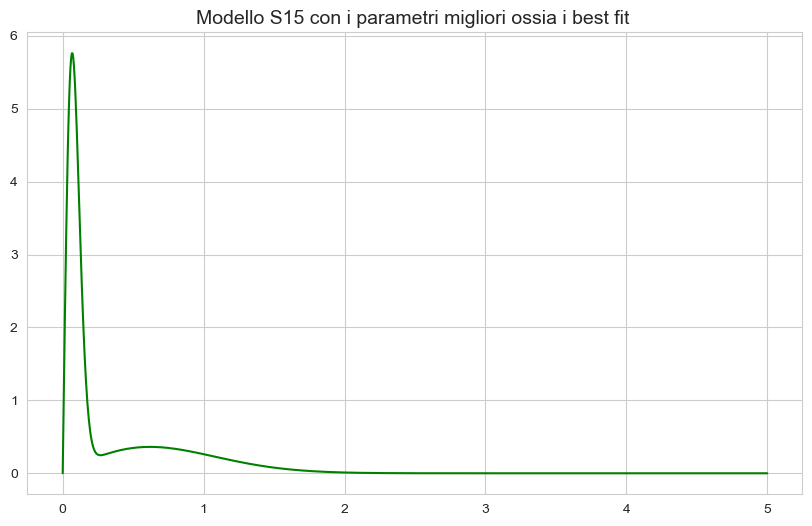

In [926]:
#Confronto i due modelli utilizzando i parametri migliori(best fit) che sono stati trovati con l'algoritmo emcee  
#Modello S15(Saro et al.2015)
#Usando i parametri migliori 
rho_best_fit1 = 0.63
sigma_0_best_fit1 = 0.067 
sigma_1_best_fit1 = 0.62

y_best_fit1 = modello_S15(x_1, rho_best_fit1, sigma_0_best_fit1, sigma_1_best_fit1) #ricordando che x_1 = np.linspace(0,5,1000)

plt.figure(figsize=(10,6))
plt.plot(x_1, y_best_fit1, color='green')
plt.title("Modello S15 con i parametri migliori ossia i best fit ", fontsize=14)
plt.show()


In questo grafico viene rappresentato il modello S15 utilizzando i valori migliori (best fit) dei parametri ottenuti dall'analisi statistica. Il modello dovrebbe descrivere la distribuzione del miscentering degli ammassi di galassie nel modo più accurato possibile, dato l'approccio utilizzato. La curva generata con i parametri best fit dovrebbe adattarsi bene ai dati, mostrando una corrispondenza ragionevole tra il modello teorico e le osservazioni. 

Il valore di $\rho$ vicino a 0.628 indica una correlazione moderata, mentre la dispersione caratterizzata da $\sigma_0$ e $\sigma_1$ suggerisce una certa ampiezza nella distribuzione. 


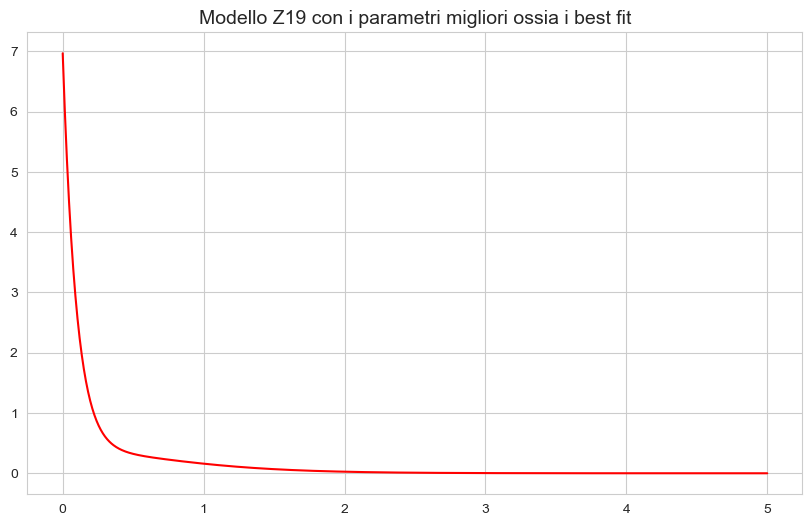

In [838]:
#Modello Z19
#Usando i parametri migliori 
rho_best_fit2 = 0.69
sigma_0_best_fit2 = 0.099
sigma_1_best_fit2 = 0.40

y_best_fit2 = modello_Z19(x_2, rho_best_fit2, sigma_0_best_fit2, sigma_1_best_fit2)  #Ricordando che x_2= np.linspace(0,5,1000)

plt.figure(figsize=(10,6))
plt.plot(x_2, y_best_fit2, color='red')
plt.title("Modello Z19 con i parametri migliori ossia i best fit", fontsize=14)
plt.show()


Qui viene mostrato il modello Z19 con i suoi parametri best fit. Rispetto al modello S15, i parametri ottenuti presentano differenze significative:

$\cdot$ $\rho$ è più alto (∼0.680), indicando una correlazione più forte rispetto a S15.

$\cdot$ La dispersione $\sigma_0$ è maggiore (∼0.0986), suggerendo una distribuzione più ampia dei dati.

$\cdot$ $\sigma_1$ è molto più basso rispetto a S15 (∼0.39 vs. ∼0.62), il che potrebbe riflettere un diverso approccio nella descrizione della varianza dei dati.

Il grafico mostrerà quindi una distribuzione leggermente diversa rispetto al modello S15, con un possibile miglior adattamento in alcune regioni ma una peggiore corrispondenza in altre.



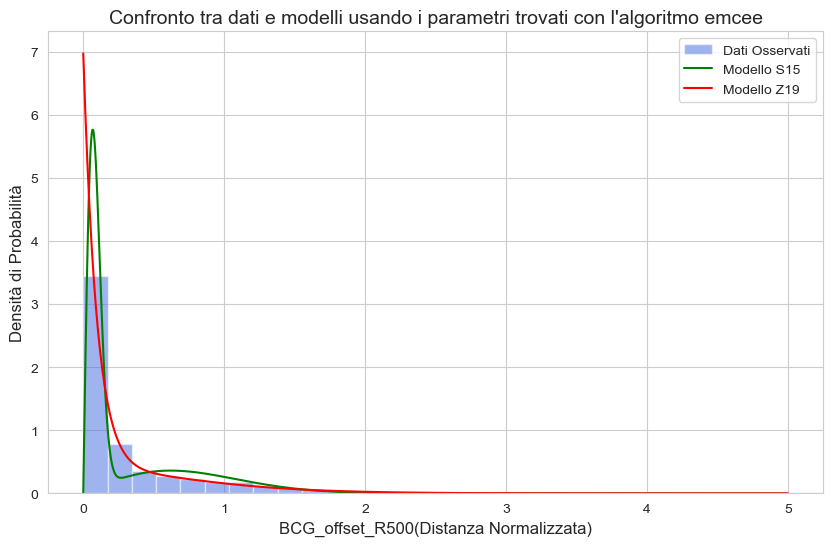

In [920]:
#Confronto tra modelli e dati 
plt.figure(figsize=(10,6))
bins = np.linspace(0,5,30)
plt.hist(d, bins= bins, density = True , color='royalblue' ,alpha=0.5, label="Dati Osservati")

#Campionamento dei modelli con parametri MCMC (usando le migliore stime ottenute dai risultati MCMC)
x_vals = np.linspace(0,5,1000)
y_S15 = modello_S15(x_vals, rho_best_fit1, sigma_0_best_fit1, sigma_1_best_fit1)
plt.plot(x_vals, y_S15, color='green', label = 'Modello S15')

y_Z19 = modello_Z19(x_vals, rho_best_fit2, sigma_0_best_fit2, sigma_1_best_fit2)
plt.plot(x_vals, y_Z19, color='red', label= 'Modello Z19')

plt.xlabel("BCG_offset_R500(Distanza Normalizzata)", fontsize=12)
plt.ylabel("Densità di Probabilità", fontsize=12)
plt.title("Confronto tra dati e modelli usando i parametri trovati con l'algoritmo emcee", fontsize=14)
plt.legend()
plt.show()

Questo grafico importante perché permette di visualizzare direttamente il livello di accordo tra i dati sperimentali e le previsioni dei due modelli. Le curve corrispondenti ai modelli S15 e Z19 dovrebbero essere tracciate insieme ai dati osservati, consentendo una comparazione visiva immediata.

È possibile notare differenze significative tra i due modelli: ad esempio, il modello S15 potrebbe funzionare meglio in una certa regione dei dati, mentre Z19 potrebbe essere più preciso in altre. In sintesi, questo grafico permette di valutare quale modello descrive meglio la distribuzione del miscentering e se ci sono sistematiche che nessuno dei due riesce a catturare completamente.

# Correlazione tra i coefficienti
Il coefficiente di correlazione $r$ è dato da:
$$
r = \frac{\text{Cov}(x, y)}{\sqrt{\text{Var}(x) \cdot \text{Var}(y)}}
$$

Per mettere in relazione **il coefficiente di correlazione $r$** con **l'angolo (o la pendenza)** dell'asse principale della distribuzione dei dati, specialmente quando le scale dei due parametri sono diverse, è necessario tenere conto della varianza di ciascun parametro. Questa relazione è legata alla **matrice di covarianza** dei dati.

#### **Autovettori della matrice di covarianza**:
L'orientazione dell'asse principale della distribuzione dei dati è determinata dall'autovettore corrispondente al valore dell'autovalore più grande della matrice di covarianza.
1. Calcola gli autovalori e gli autovettori della matrice di covarianza:
      $$
   C \cdot \mathbf{v} = \lambda \mathbf{v}
   $$
dove $\lambda $ è un autovalore e $\mathbf{v}$ è l'autovettore corrispondente.
2. L'autovettore associato al valore più grande indica la direzione dell'asse principale.

#### La pendenza
La pendenza $m$ dell'asse principale può anche essere espressa come:
$$
m = \frac{v_y}{v_x}
$$


Matrice di correlazione
[[1.   0.38 0.19]
 [0.38 1.   0.29]
 [0.19 0.29 1.  ]]


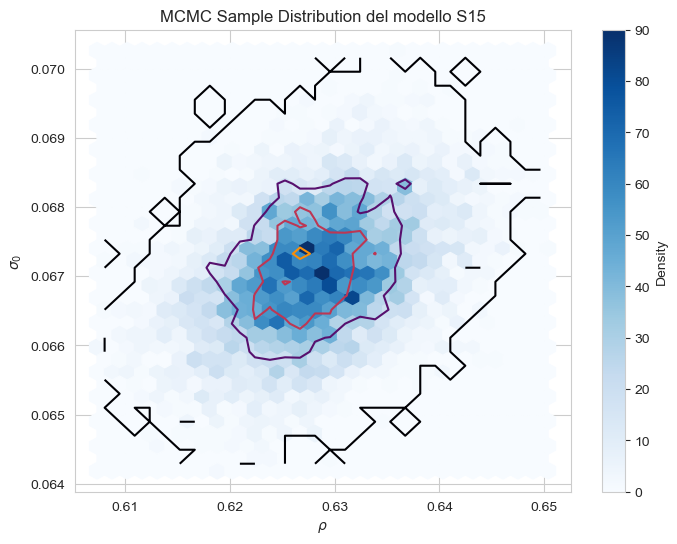

Slope dell'Asse Maggiore: 0.05019027433138492


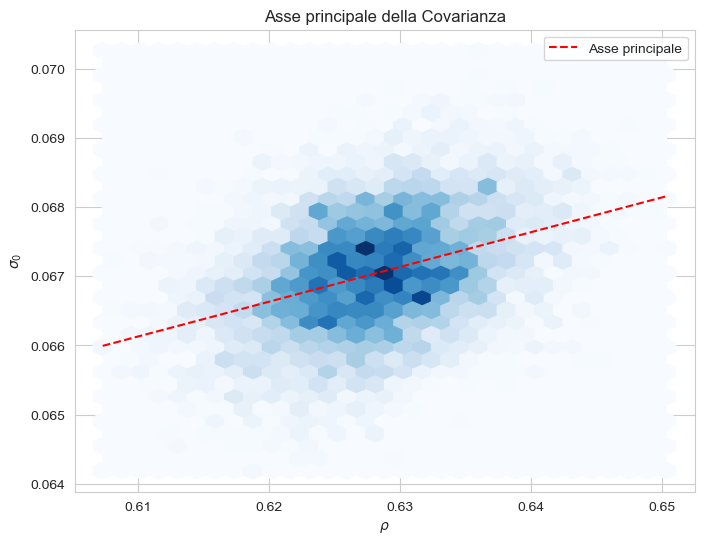

In [910]:
#Correlazione tra i coefficienti 
corr = np.corrcoef(emcee_sample_S15.T)
print("Matrice di correlazione")
print(np.round(corr,2))

#Creazione di un istogramma 2D (hexbin)
plt.figure(figsize=(8,6))
plt.hexbin(emcee_sample_S15[:,0], emcee_sample_S15[:,1], gridsize=30, cmap="Blues")
plt.colorbar(label="Density")

#Creazione di un istogramma 2D per il contour plotting
hist, xedges, yedges = np.histogram2d(emcee_sample_S15[:,0], emcee_sample_S15[:,1], bins=30)

#Creazione del meshgrid for plotting contour 
X,Y = np.meshgrid(
    0.5 * (xedges[:-1]+ xedges[1:]),   #Bin centers per x 
    0.5 * (yedges[:-1] + yedges[1:])   #Bin centers per y
)

#Plot per il contour 
plt.contour(X,Y, hist, levels=3, cmap= "inferno")   #Livelli determinano il numero dei contours 
plt.xlabel(r"$\rho$")
plt.ylabel(r"$\sigma_0$")
plt.title("MCMC Sample Distribution del modello S15")
plt.show()

#Calcolo della matrice di covarianza
cov_matrix = np.cov(emcee_sample_S15[:,0], emcee_sample_S15[:, 1])

#Calcolo eigenvalues and eigenvectors (autovettori e autovalori)
eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)

#Asse Maggiore: eigenvector corrispondente al più grande eigenvalue
major_axis = eigenvectors[:, np.argmax(eigenvalues)]
slope = major_axis[1] / major_axis[0]  #Calcolo della pendenza 

print("Slope dell'Asse Maggiore:", slope)

#Definizione il range per il plotting 
rho_vals = np.linspace(min(emcee_sample_S15[:,0]), max(emcee_sample_S15[:,0]),50)

#Plot principale dell'asse di correlazione 
plt.figure(figsize=(8,6))
plt.hexbin(emcee_sample_S15[:,0], emcee_sample_S15[:,1], gridsize=30, cmap="Blues")
plt.plot(rho_vals, slope*(rho_vals -np.mean(emcee_sample_S15[:,0]))+np.mean(emcee_sample_S15[:,1]), 
         color="red", linestyle="--", label= "Asse principale")
plt.xlabel(r"$\rho$")
plt.ylabel(r"$\sigma_0$")
plt.legend()
plt.title("Asse principale della Covarianza")
plt.show()

Il primo grafico rappresenta la distribuzione dei campioni MCMC per il modello S15. Le linee di contorno mostrano la densità della distribuzione, evidenziando la regione di maggiore probabilità per i parametri stimati. La presenza di una forma ellittica e ben definita suggerisce una buona esplorazione dello spazio dei parametri e una convergenza accettabile della catena MCMC.

Il secondo grafico mostra la stessa distribuzione di campioni MCMC per S15 ma con l'aggiunta dell’asse principale della covarianza, rappresentato dalla linea tratteggiata rossa. L’inclinazione di questa retta riflette la correlazione tra i due parametri analizzati. L'orientamento dell'asse maggiore indica la direzione di massima varianza, fornendo informazioni sulla dipendenza tra le variabili.


Matrice di correlazione
[[1.   0.52 0.48]
 [0.52 1.   0.41]
 [0.48 0.41 1.  ]]


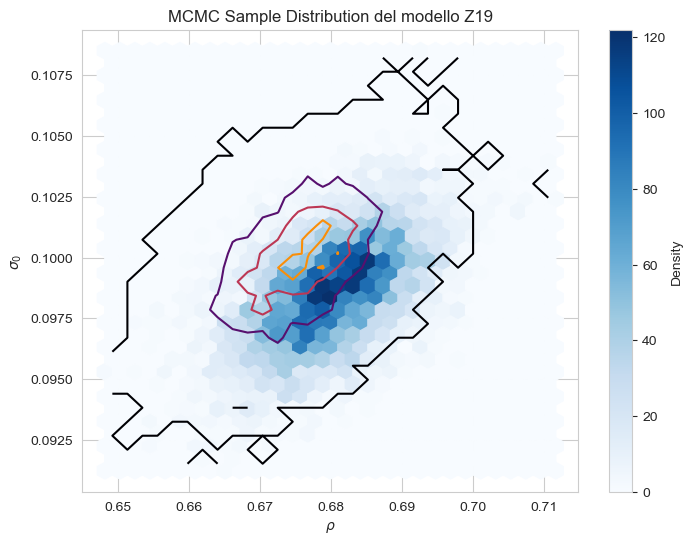

Slope dell'Asse Maggiore: 0.1472458014219764


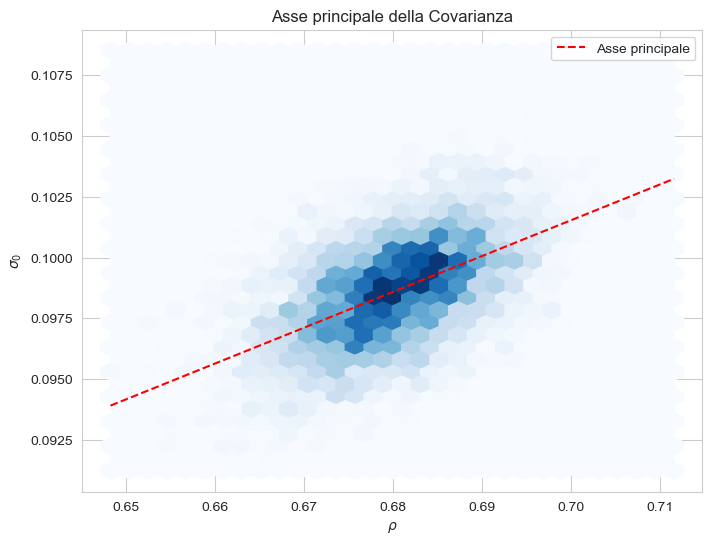

In [911]:
#Correlazione tra i coefficienti 
corr = np.corrcoef(emcee_sample_Z19.T)
print("Matrice di correlazione")
print(np.round(corr,2))

#Creazione di un istogramma 2D (hexbin)
plt.figure(figsize=(8,6))
plt.hexbin(emcee_sample_Z19[:,0], emcee_sample_Z19[:,1], gridsize=30, cmap="Blues")
plt.colorbar(label="Density")

#Creazione di un istogramma 2D per il contour plotting
hist, xedges, yedges = np.histogram2d(emcee_sample_Z19[:,0], emcee_sample_Z19[:,1], bins=30)

#Creazione del meshgrid for plotting contour 
X,Y = np.meshgrid(
    0.5 * (xedges[:-1]+ xedges[1:]),   #Bin centers per x 
    0.5 * (yedges[:-1] + yedges[1:])   #Bin centers per y
)

#Plot per il contour 
plt.contour(X,Y, hist, levels=3, cmap= "inferno")   #Livelli determinano il numero dei contours 
plt.xlabel(r"$\rho$")
plt.ylabel(r"$\sigma_0$")
plt.title("MCMC Sample Distribution del modello Z19")
plt.show()

#Calcolo della matrice di covarianza
cov_matrix = np.cov(emcee_sample_Z19[:,0], emcee_sample_Z19[:, 1])

#Calcolo eigenvalues and eigenvectors
eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)

#Asse Maggiore: eigenvector corrispondente al più grande eigenvalue
major_axis = eigenvectors[:, np.argmax(eigenvalues)]
slope = major_axis[1] / major_axis[0]

print("Slope dell'Asse Maggiore:", slope)

#Definire il range per il plotting 
rho_vals = np.linspace(min(emcee_sample_Z19[:,0]), max(emcee_sample_Z19[:,0]),50)

#Plot principale dell'asse di correlazione QU
plt.figure(figsize=(8,6))
plt.hexbin(emcee_sample_Z19[:,0], emcee_sample_Z19[:,1], gridsize=30, cmap="Blues")
plt.plot(rho_vals, slope*(rho_vals -np.mean(emcee_sample_Z19[:,0]))+np.mean(emcee_sample_Z19[:,1]), 
         color="red", linestyle="--", label= "Asse principale")
plt.xlabel(r"$\rho$")
plt.ylabel(r"$\sigma_0$")
plt.legend()
plt.title("Asse principale della Covarianza")
plt.show()

Anche qui nel primo grafico viene mostrata la distribuzione dei campioni MCMC per il modello Z19. Analogamente al grafico precedente, le linee di contorno indicano le regioni di maggiore densità. Rispetto al modello S15, la distribuzione sembra avere una maggiore elongazione, suggerendo una correlazione più forte tra i parametri. Anche in questo caso, la convergenza della catena appare soddisfacente.

Come nel secondo grafico, qui viene mostrata la distribuzione dei campioni MCMC per Z19 con l’asse principale della covarianza. L'inclinazione della retta tratteggiata indica la correlazione tra i parametri, che risulta più marcata rispetto al caso del modello S15. Ciò suggerisce che le incertezze tra i parametri siano più dipendenti tra loro in questo modello.


## Verifica della bontà del fit
Per poter verificare la bontà di un fit si possono seguire i seguenti step:
1. Confrontare i dati con la media e il best fit del modello
2. Confrontare i dati con un campione di modelli estratti dalla catena
3. Calcolare il $\chi^2$ (ridotto) del best-fit

Text(0, 0.5, 'Residui(Dati-Modello S15)')

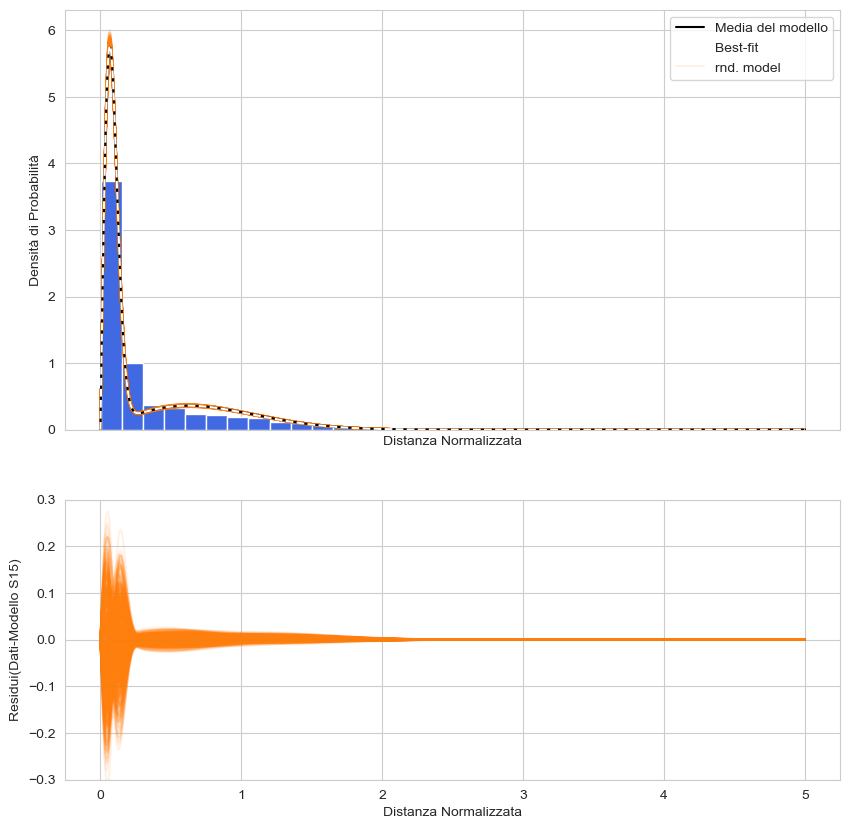

In [921]:
#Definiamo un array x_1 
x_vals = np.linspace(0,5,1000)

fig, ax = plt.subplots(2, figsize=(10,10), sharex=True, gridspec_kw = {'height_ratios':[3,2]})
ax[0].hist(d, bins=30, density=True, color="royalblue")

#Modello che usa le  medie a posteriori
rho, sigma_0, sigma_1 = means_S15
y_S15_mean = modello_S15(x_vals, rho, sigma_0, sigma_1)
ax[0].plot(x_vals, y_S15_mean, c="k", zorder=10 , label='Media del modello')

#Modello che utilizza i Best fit 
y_best_fit1 = modello_S15(x_vals, rho_best_fit1,sigma_0_best_fit1, sigma_1_best_fit1)
ax[0].plot(x_vals, y_best_fit1, c="w", ls= '--', zorder=11, label='Best-fit')

#Estrae N=1000 campioni dalla catena e traccia rispetto ai dati 
N=1000  #Numero di punti campionati dalla catena
inds= np.random.randint(len(emcee_sample_S15), size=N)  #Definisci indici casuali da campionare
for ind in inds:
    rho, sigma_0, sigma_1 = emcee_sample_S15[ind]
    y_S15 = modello_S15(x_vals, rho, sigma_0, sigma_1)
    if ind==inds[0]:
        ax[0].plot(x_vals, y_S15, "C1", alpha=0.1, label='rnd. model')
    else:
        ax[0].plot(x_vals, y_S15, "C1", alpha=0.1)
    ax[1].plot(x_vals,(y_S15)-(y_best_fit1), "C1", alpha=0.1)  #Calcolo degli scarti semplici con la sottrazione 

ax[0].set_xlabel('Distanza Normalizzata')
ax[0].set_ylabel('Densità di Probabilità')   

ax[0].legend()

ax[1].set_ylim(-0.3, 0.3)
ax[1].set_xlabel('Distanza Normalizzata')
ax[1].axhline(1., ls='--', c='gray')
ax[1].set_ylabel('Residui(Dati-Modello S15)')

Il primo grafico mostra il confronto tra il modello S15 e i dati osservati. La distribuzione dei dati (in blu) segue un andamento decrescente, e la curva del modello (linea tratteggiata arancione) sembra adattarsi bene nella parte iniziale, ma mostra qualche discrepanza nelle code della distribuzione. Nel grafico inferiore, che rappresenta i residui (differenza tra dati e modello), si nota un andamento oscillatorio attorno allo zero con una maggiore dispersione nelle regioni iniziali. Questo suggerisce che il modello S15 cattura la tendenza generale, ma potrebbe avere difficoltà a descrivere con precisione alcune caratteristiche specifiche della distribuzione.

Text(0, 0.5, 'Residui(Dati - Modello Z19)')

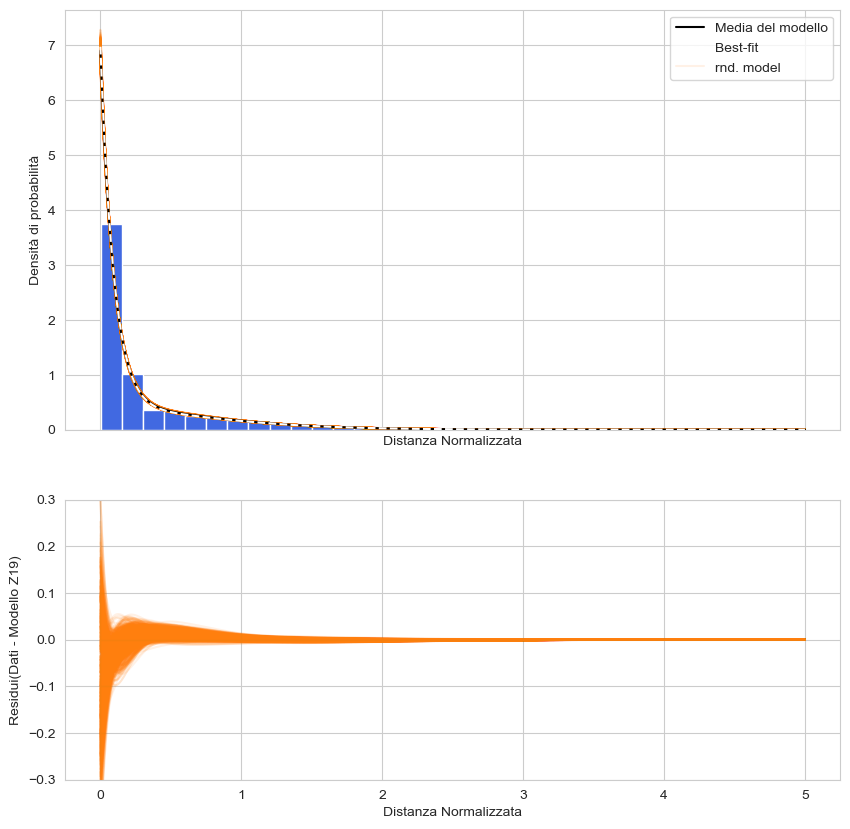

In [922]:
#Definiamo un array x_1 
x_vals = np.linspace(0,5,1000)

fig, ax = plt.subplots(2, figsize=(10,10), sharex=True, gridspec_kw = {'height_ratios':[3,2]})
ax[0].hist(d, bins=30, density=True, color="royalblue")

#Modello che utilizza le medie a posteriori 
rho, sigma_0, sigma_1 = means_Z19
y_Z19_mean = modello_Z19(x_vals, rho, sigma_0, sigma_1)
ax[0].plot(x_vals, y_Z19_mean, c="k", zorder=10 , label='Media del modello')

#Modello che utilizza  i best fit 
#rho, sigma_0,sigma_1 = best_fits_Z19
y_best_fit2 = modello_Z19(x_vals, rho_best_fit2,sigma_0_best_fit2, sigma_1_best_fit2)
ax[0].plot(x_vals, y_best_fit2, c="w", ls= '--', zorder=11, label='Best-fit')

#Estrai N=1000 campioni dalla catena e tracciali rispetto ai dati
N=1000   #Numero di punti campionati dalla catena
inds= np.random.randint(len(emcee_sample_Z19), size=N)  #Definisci indici casuali da campionare
for ind in inds:
    rho, sigma_0, sigma_1 = emcee_sample_Z19[ind]
    y_Z19 = modello_Z19(x_vals, rho, sigma_0, sigma_1)
    if ind==inds[0]:
        ax[0].plot(x_vals, y_Z19, "C1", alpha=0.1, label='rnd. model')
    else:
        ax[0].plot(x_vals, y_Z19, "C1", alpha=0.1)
    ax[1].plot(x_vals,(y_Z19)-(y_best_fit2), "C1", alpha=0.1)  #Calcolo degli scarti semplici con la sottrazione 

ax[0].set_xlabel('Distanza Normalizzata')
ax[0].set_ylabel('Densità di probabilità')   
ax[0].legend()

ax[1].set_ylim(-0.3, 0.3)
ax[1].set_xlabel('Distanza Normalizzata')
ax[1].axhline(1., ls='--', c='gray')
ax[1].set_ylabel('Residui(Dati - Modello Z19)')

Questo grafico è analogo a quello precedente, ma riguarda il modello Z19. Anche in questo caso, la distribuzione dei dati osservati segue una tendenza decrescente, con la curva del modello che si adatta abbastanza bene nella parte iniziale ma mostra alcune discrepanze nelle code. Il grafico inferiore dei residui mostra un comportamento simile a quello del modello S15, con oscillazioni attorno allo zero, suggerendo che il modello Z19 riproduce la struttura principale ma con alcune imprecisioni locali.

## Calcolo del chi quadro 
Il test del chi-quadro si usa per confrontare i dati osservati con quelli attesi secondo un modello.


### Formula del chi quadro ridotto 
$\chi_{\rm BF,red}^2 = \frac{\chi_{\rm BF}^2}{\nu}$

$\nu={\rm Num. data}-{\rm Num. paramaters}$

### Interpretazione del chi quadro ridotto 
- **$(\chi^2_{\text{red}} \approx 1$)**: Il modello è un buon fit per i dati (I residui sono dello stesso ordine di grandezza delle incertezze.)
  
- **$(\chi^2_{\text{red}} > 1$)**:Il modello potrebbe non fittare bene.
  
- **$(\chi^2_{\text{red}} \gg 1$)**:Indica la presenza di errori sistematici, una sottostima delle incertezze o un modello non adeguato.

  
- **$(\chi^2_{\text{red}} < 1$)**: Il modello potrebbe essere in overfitting oppure le incertezze potrebbero essere sovrastimate.

In [876]:
# Funzione per calcolare il chi-quadro per un modello dato
def calcola_chi2(y_obs, xcentro, dx, modello, *params):
    """
    Calcola il chi-quadro tra i dati osservati (y_obs) e il modello teorico (modello)
    
    Parametri:
    - y_obs: Frequenze osservate dall'istogramma
    - xcentro: Centri dei bin dell'istogramma
    - dx: Larghezza dei bin
    - modello: Funzione del modello (S15 o Z19)
    - params: Parametri del modello (ρ, σ_0, σ_1)
    
    Restituisce:
    - Chi-quadro
    - Gradi di libertà
    """
    p = modello(xcentro, *params) * dx  # Probabilità predette dal modello
    mu = np.sum(y_obs) * p  # Frequenze attese, calcola il numero atteso di eventi per ogni bin usando le probabilità p e il totale dei dati osservati.
    sigma = np.sqrt(mu)  # Errore statistico (Poisson)

    # Filtro: consideriamo solo bin con frequenze attese > 5
    filtro = mu > 5
    if np.sum(filtro) == 0:
        raise ValueError("Troppi bin eliminati, verifica la parametrizzazione!")

    chi2_val = np.sum(((y_obs[filtro] - mu[filtro])**2) / mu[filtro])   #Calcolo esplicito del chi quadro
    gradi_di_libertà = np.sum(filtro) - len(params)  # Ndof = bin validi - parametri

    return chi2_val, gradi_di_libertà

# Caricamento dati
x_vals = np.linspace(0,5,1000)  # Campione dati
nbin = 100  # Numero di bin


# Calcolo centri e larghezze dei bin
xcentro = (x_edges[1:] + x_edges[:-1]) / 2
dx = x_edges[1:] - x_edges[:-1]

# Calcolo del chi-quadro per i due modelli
chi2_S15, dof_S15 = calcola_chi2(y_obs, xcentro, dx, modello_S15, rho_best_fit1, sigma_0_best_fit1, sigma_1_best_fit1)
chi2_Z19, dof_Z19 = calcola_chi2(y_obs, xcentro, dx, modello_Z19, rho_best_fit2, sigma_0_best_fit2, sigma_1_best_fit2)

# Calcolo del chi-quadro ridotto
reduced_chi2_S15 = chi2_S15 / dof_S15
reduced_chi2_Z19 = chi2_Z19 / dof_Z19

# Stampa risultati
print(f"Chi-quadro per il modello S15: {chi2_S15:.2f}")
print(f"Chi-quadro ridotto per il modello S15: {reduced_chi2_S15:.2f}")
print(f"Chi-quadro per il modello Z19: {chi2_Z19:.2f}")
print(f"Chi-quadro ridotto per il modello Z19: {reduced_chi2_Z19:.2f}")
print(f"Valore critico (alpha=0.95) per S15: {chi2.ppf(0.95, dof_S15):.2f}")
print(f"Valore critico (alpha=0.95) per Z19: {chi2.ppf(0.95, dof_Z19):.2f}")

Chi-quadro per il modello S15: 626.62
Chi-quadro ridotto per il modello S15: 25.06
Chi-quadro per il modello Z19: 636.31
Chi-quadro ridotto per il modello Z19: 27.67
Valore critico (alpha=0.95) per S15: 37.65
Valore critico (alpha=0.95) per Z19: 35.17


Questi risultati mostrano il test del $\chi^2$ per valutare la bontà dell’adattamento dei modelli S15 e Z19 ai dati. 
Si nota guardando i risultati ottenuti per il modello S15 che il valore di $\chi^2$ ridotto è molto più grande di 1, il che suggerisce che il modello S15 non si adatta bene ai dati. Questo può indicare che il modello è troppo rigido per descrivere la distribuzione osservata o che le incertezze nei dati sono sottostimate.

Anche nel caso del modello Z19, il $\chi^2$ ridotto è molto elevato, suggerendo che il modello Z19 non fornisce un buon adattamento ai dati. Le possibili cause potrebbero essere la presenza di errori sistematici, una cattiva modellizzazione della distribuzione o una sottostima delle incertezze.

Entrambi i modelli hanno un valore di $\chi^2 $ridotto molto superiore a 1, indicando che nessuno dei due modelli descrive bene i dati. Si potrebbe considerare una revisione dei modelli, un’eventuale ridefinizione delle incertezze o un miglioramento nella scelta dei parametri.


## Conclusioni 
I modelli analizzati forniscono una buona prima approssimazione dei dati, ma presentano delle limitazioni evidenziate dai residui e dai valori del $\chi^2$. È possibile che vi siano effetti sistematici o incertezze sottostimate che influenzano il fit. Un affinamento del modello, un miglioramento della stima delle incertezze o l'introduzione di componenti aggiuntive nel modello potrebbero migliorare la qualità del fit e ridurre le discrepanze osservate.
Perciò il modello proposto riesce a catturare la struttura generale della distribuzione di miscentering, ma potrebbe essere migliorato considerando ulteriori effetti, come la dipendenza esplicita dalla morfologia degli ammassi o dalla loro dinamica interna.





